<a href="https://colab.research.google.com/github/monkrus/anomaly_detect/blob/main/Anomaly2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import glob


In [ ]:
# Set up the Kaggle API
os.environ['KAGGLE_USERNAME'] = 'your_username'  # replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_key'  # replace with your Kaggle key


In [ ]:
# Download dataset from Kaggle
try:
    os.system('kaggle datasets download -d mlg-ulb/creditcardfraud')
except OSError:
    print('Invalid Kaggle API credentials. Please check your username and key.')

# Unzip the downloaded dataset
try:
    with zipfile.ZipFile('creditcardfraud.zip', 'r') as zip_ref:
        zip_ref.extractall()
except FileNotFoundError:
    print('Dataset download failed. Please check your internet connection and try again.')

# Load the dataset
data = pd.read_csv('creditcard.csv')  # Update the filename if needed
if data.empty:
    print('The CSV file is empty. Please check the file.')


In [ ]:
# Inspect the data
print(data.head())
print(data.info())
print(data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create the anomaly detection model
model = IsolationForest()

In [ ]:
# Define the grid of hyperparameters to search
grid = {
    'contamination': [0.001, 0.01, 0.1],
}




In [ ]:
# Perform grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=IsolationForest(),
             param_grid={'contamination': [0.001, 0.01, 0.1]},
             scoring='roc_auc')

In [ ]:
# Get the best model
model = grid_search.best_estimator_

In [ ]:
# Train the model on the training dataset
model.fit(X_train)

IsolationForest(contamination=0.01)

In [ ]:
# Predict outliers/anomalies
scores_test = model.decision_function(X_test)
predictions = model.predict(X_test)

In [ ]:
# Adjust the labels for the confusion matrix and classification report
y_test_adj = y_test.copy()
y_test_adj[y_test_adj == 1] = -1
y_test_adj[y_test_adj == 0] = 1
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1


In [ ]:
# Evaluate the performance
print("Overall Metrics:")
print(classification_report(y_test_adj, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test_adj, predictions))


Overall Metrics:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        98
           0       0.00      0.00      0.00         0
           1       0.91      0.01      0.02     56864

    accuracy                           0.01     56962
   macro avg       0.30      0.00      0.01     56962
weighted avg       0.91      0.01      0.02     56962

Confusion Matrix:
[[    0    46    52]
 [    0     0     0]
 [    0 56338   526]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

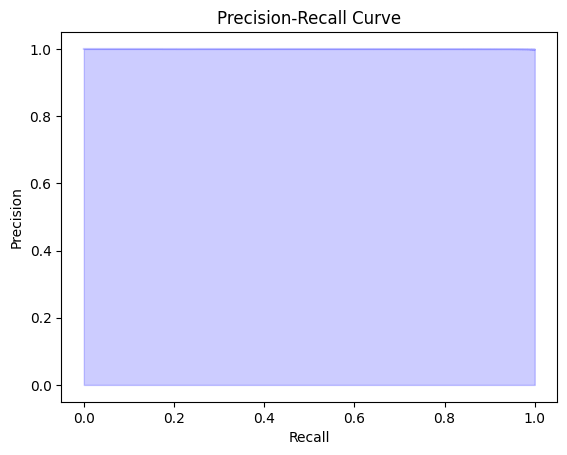

In [ ]:

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_adj, scores_test)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, color='b', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


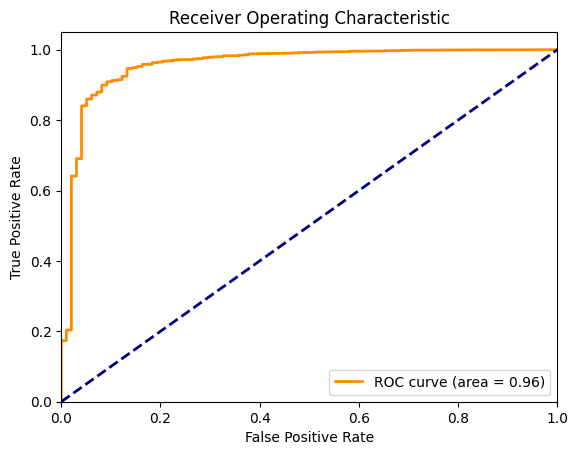

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_adj, scores_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

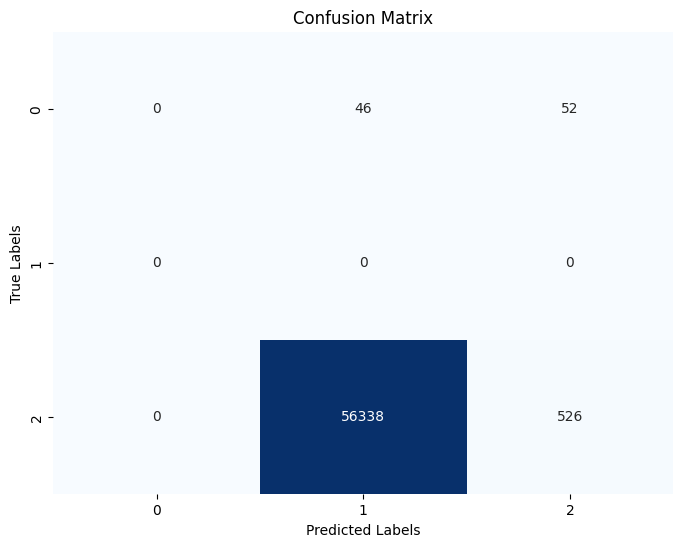

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_adj, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()